In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='face_mask.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('face_mask.zip')
f.keys()
!unzip face_mask.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1870.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1871.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1872.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Encoding and Split data into Train/Test Sets
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Tensorflow Keras CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop



In [ ]:
train_dir = '/content/Face Mask Dataset/Train'
validation_dir = '/content/Face Mask Dataset/Validation'
test_dir='/content/Face Mask Dataset/Test'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
no_classes = 2

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names
print(class_names)



Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
['WithMask', 'WithoutMask']


In [ ]:
# Transfer Learning Model
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
)

transfer_learning_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

for layer in base_model.layers:
    layer.trainable = False

transfer_learning_model.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = transfer_learning_model.fit(train_dataset, epochs=5, validation_data=validation_dataset)

# Fine Tuning Model
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
)

for layer in base_model.layers:
    layer.trainable = True

fine_tuning_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

fine_tuning_model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history3 = fine_tuning_model.fit(train_dataset, epochs=5, validation_data=validation_dataset)




58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/5
313/313 [==============================] - 60s 150ms/step - loss: 1.1194 - accuracy: 0.9890 - val_loss: 0.3460 - val_accuracy: 0.9950
Epoch 2/5
313/313 [==============================] - 47s 150ms/step - loss: 0.2846 - accuracy: 0.9964 - val_loss: 0.4267 - val_accuracy: 0.9937
Epoch 3/5
313/313 [==============================] - 48s 154ms/step - loss: 0.1622 - accuracy: 0.9971 - val_loss: 0.5642 - val_accuracy: 0.9962
Epoch 4/5
313/313 [==============================] - 47s 150ms/step - loss: 0.2327 - accuracy: 0.9981 - val_loss: 0.5288 - val_accuracy: 0.9987
Epoch 5/5
313/313 [==============================] - 46s 145ms/step - loss: 0.2589 - accuracy: 0.9976 - val_loss: 0.2385 - val_accuracy: 0.9962
Epoch 1/5
313/313 [==============================] - 156s 454ms/step - loss: 0.1351 - accuracy: 0.9730 - val_loss: 0.1405 - val_accuracy: 0.9737
Epoch 2/5
313/313 [==============================] - 137s 437ms/step -

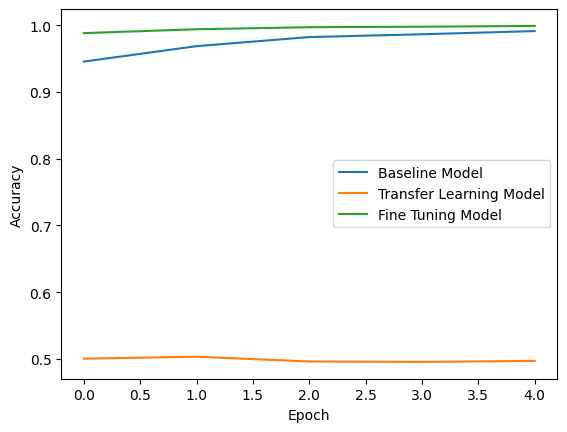

In [ ]:

plt.plot(history2.history['accuracy'], label='Transfer Learning Model')
plt.plot(history3.history['accuracy'], label='Fine Tuning Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Evaluate the models on validation dataset

loss2, accuracy2 = transfer_learning_model.evaluate(test_dataset)
loss3, accuracy3 = fine_tuning_model.evaluate(test_dataset)

print('Transfer Learning Model Accuracy:', accuracy2)
print('Fine Tuning Model Accuracy:', accuracy3)




31/31 [==============================] - 5s 144ms/step - loss: 0.0566 - accuracy: 0.9980
Baseline Model Accuracy: 0.9798387289047241
Transfer Learning Model Accuracy: 0.5131048560142517
Fine Tuning Model Accuracy: 0.9979838728904724


1/1 [==============================] - 0s 146ms/step


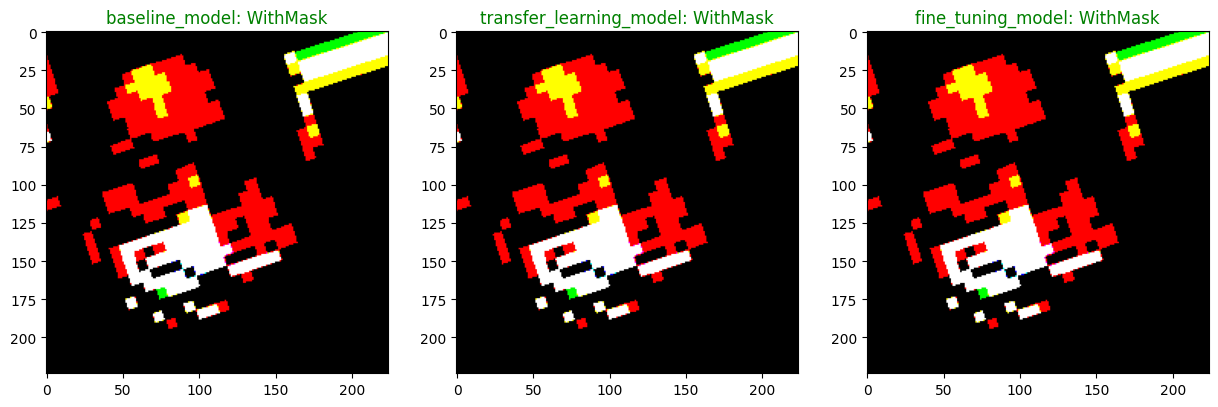

1/1 [==============================] - 0s 26ms/step


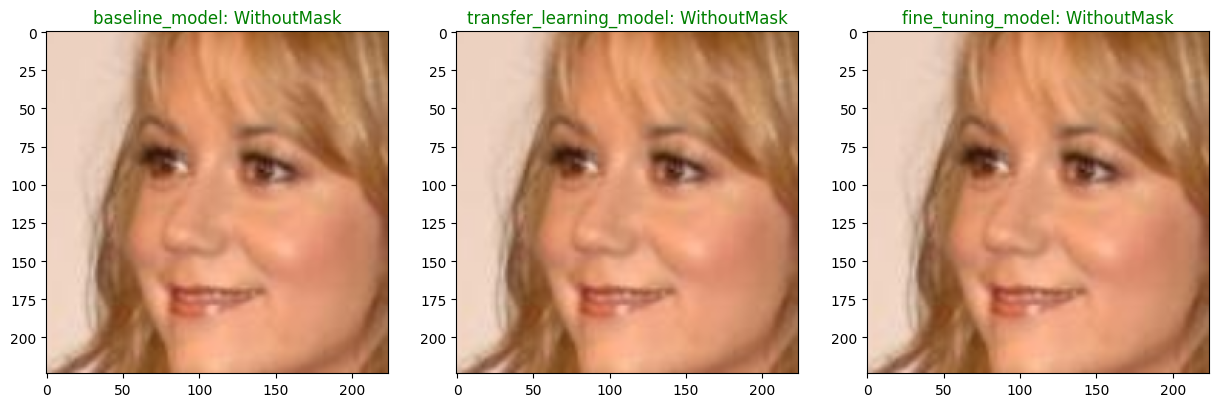

1/1 [==============================] - 0s 24ms/step


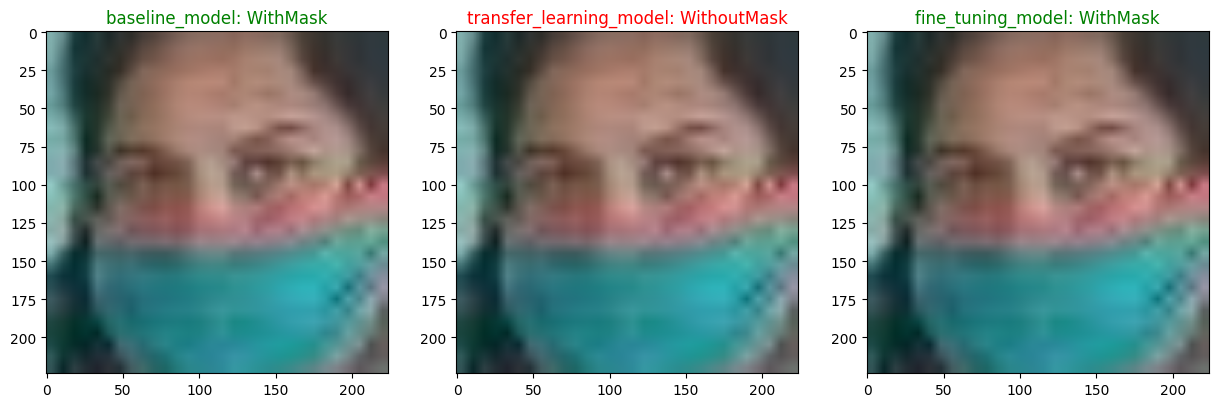

1/1 [==============================] - 0s 22ms/step


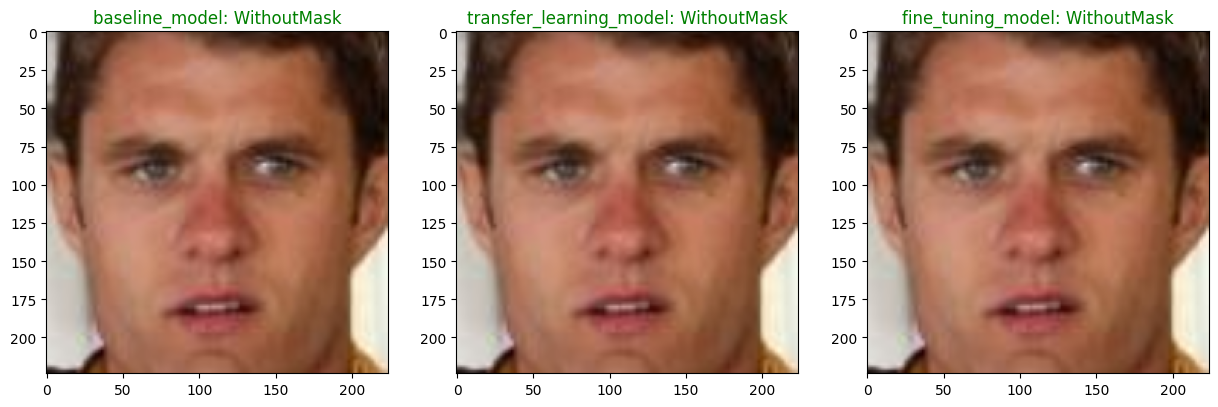

1/1 [==============================] - 0s 33ms/step


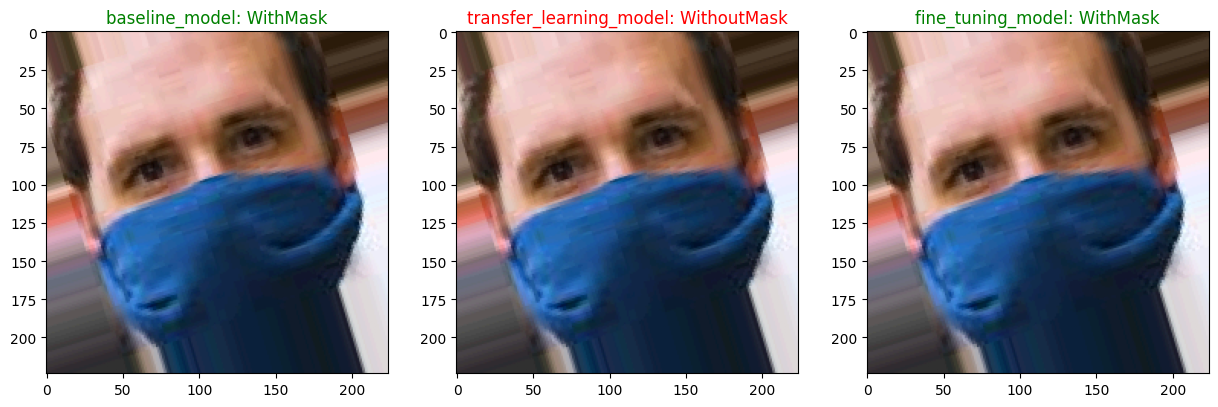

1/1 [==============================] - 0s 31ms/step


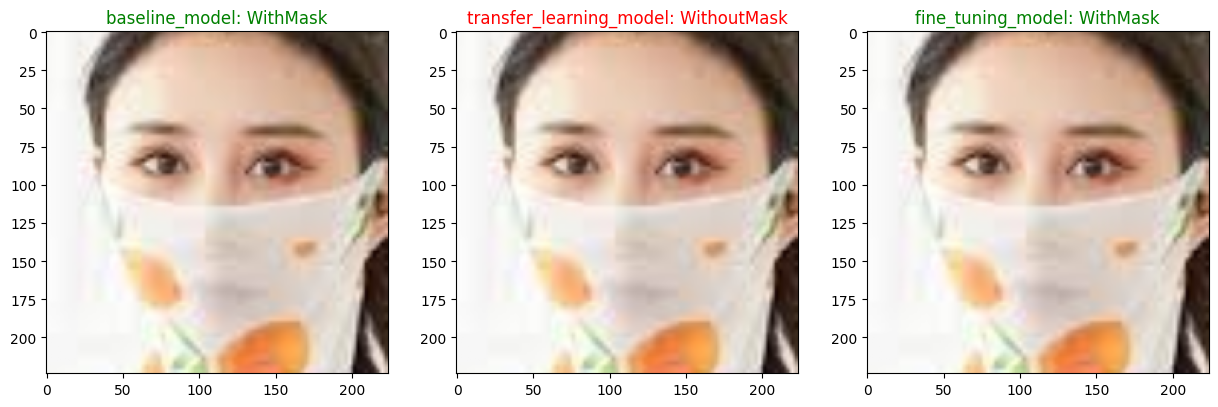

1/1 [==============================] - 0s 35ms/step


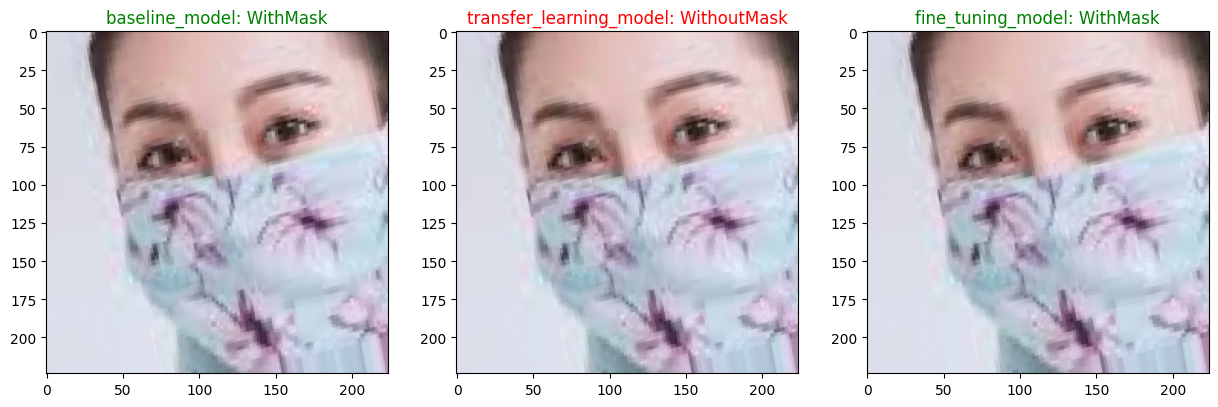

1/1 [==============================] - 0s 40ms/step


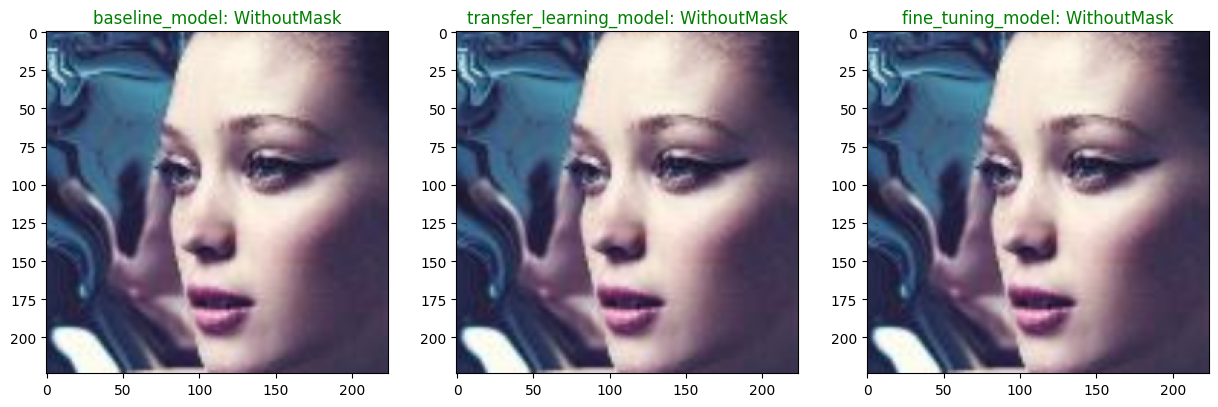

1/1 [==============================] - 0s 22ms/step


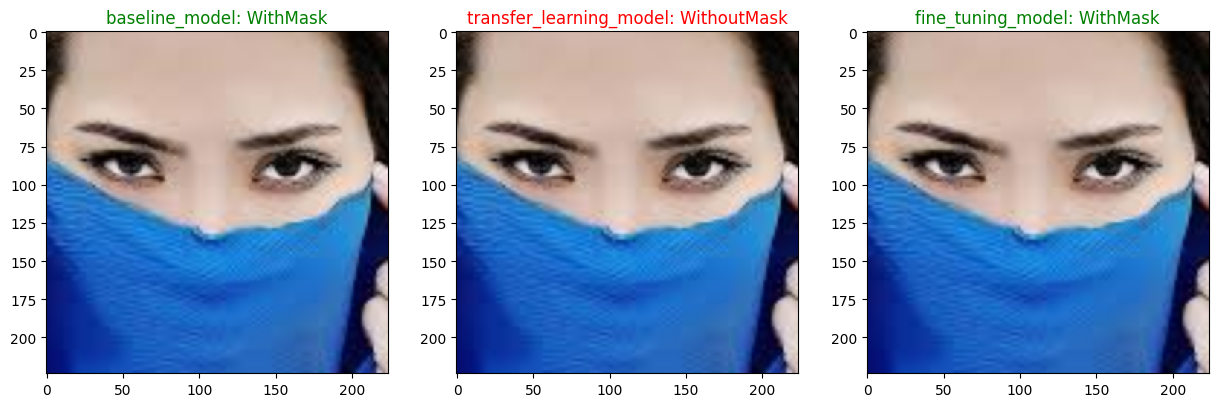

In [ ]:
# Get a batch of random images from the validation dataset
images, labels = next(iter(validation_dataset.take(1)))

for i in range(9):
    # Make predictions using the trained model

    predictions2 = transfer_learning_model.predict(np.array([images[i]]))
    predictions3 = fine_tuning_model.predict(np.array([images[i]]))


    predicted_classes2 = np.argmax(predictions2, axis=1)
    predicted_classes3 = np.argmax(predictions3, axis=1)

    # Normalize the pixel values to be within the valid range of 0 to 1
    image_normalized = images[i] / 255.0

    # Plot the image and predicted classes with labels
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(image_normalized)
    if predicted_classes1 == labels[i]:
        ax1.set_title('baseline_model: '+ class_names[predicted_classes1[0]], color='green')
    else:
        ax1.set_title('baseline_model: '+ class_names[predicted_classes1[0]], color='red')

    ax2.imshow(image_normalized)
    if predicted_classes2 == labels[i]:
        ax2.set_title('transfer_learning_model: '+ class_names[predicted_classes2[0]], color='green')
    else:
        ax2.set_title('transfer_learning_model: '+ class_names[predicted_classes2[0]], color='red')

    ax3.imshow(image_normalized)
    if predicted_classes3 == labels[i]:
        ax3.set_title('fine_tuning_model: '+ class_names[predicted_classes3[0]], color='green')
    else:
        ax3.set_title('fine_tuning_model: '+ class_names[predicted_classes3[0]], color='red')

    plt.show()




In [ ]:
# Save the trained model to the specified path
baseline_model.save('/content/Face Mask Dataset/base_line_model.h5')
transfer_learning_model.save('/content/Face Mask Dataset/transfer_learning_model.h5')
fine_tuning_model.save('/content/Face Mask Dataset/fine_tuning_model.h5')

print("Models saved successfully!")


Models saved successfully!


1/1 [==============================] - 0s 212ms/step
Base line model prediction: WithMask
Transfer learning model prediction: WithMask
Fine tuning model prediction: WithMask


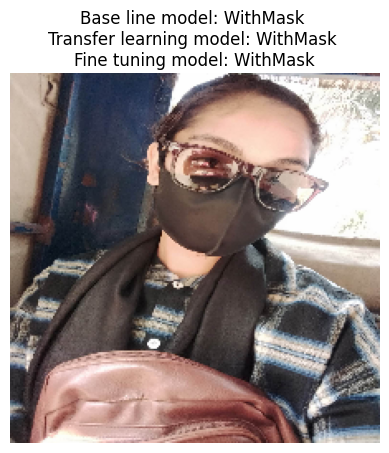

In [ ]:
#Test Random Picture
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved models
base_line_model = tf.keras.models.load_model('/content/Face Mask Dataset/base_line_model.h5')
transfer_learning_model = tf.keras.models.load_model('/content/Face Mask Dataset/transfer_learning_model.h5')
fine_tuning_model = tf.keras.models.load_model('/content/Face Mask Dataset/fine_tuning_model.h5')

# Define the class names
class_names = train_dataset.class_names

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img('/content/Face Mask Dataset/random_pic6.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

# Make predictions using the models
base_line_predictions = base_line_model.predict(img_array)
transfer_learning_predictions = transfer_learning_model.predict(img_array)
fine_tuning_predictions = fine_tuning_model.predict(img_array)

# Get the predicted classes
base_line_class_idx = np.argmax(base_line_predictions)
transfer_learning_class_idx = np.argmax(transfer_learning_predictions)
fine_tuning_class_idx = np.argmax(fine_tuning_predictions)

# Print the predicted classes
print('Base line model prediction:', class_names[base_line_class_idx])
print('Transfer learning model prediction:', class_names[transfer_learning_class_idx])
print('Fine tuning model prediction:', class_names[fine_tuning_class_idx])

# Display the image with the predicted class labels
plt.imshow(img)
plt.title(f'Base line model: {class_names[base_line_class_idx]} \nTransfer learning model: {class_names[transfer_learning_class_idx]} \nFine tuning model: {class_names[fine_tuning_class_idx]}')
plt.axis('off')
plt.show()




